# Poker Agent V19: Hybrid Training with Massive Bust Penalty

Key features:
- 6-player table (agent + 5 opponents)
- **Hybrid training**: 33% scripted, 33% self-play, 34% mixed sessions
- **Phased training**: First 1000 sessions use 60% scripted (learn basics first)
- **Massive bust penalty**: -200 BB (busting = game over)
- **Stronger all-in loss penalty**: -15 BB base
- 30 hands per session
- Dynamic epsilon decay based on training duration

In [2]:
import sys
import os
# Add project root and src directories to path
project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) if '__file__' in dir() else os.getcwd()
while 'src' not in os.listdir(project_root) and project_root != '/':
    project_root = os.path.dirname(project_root)
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'src', 'models'))
sys.path.insert(0, os.path.join(project_root, 'src', 'workers'))

import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

from poker_worker_v19 import run_session_v19, POSITION_NAMES
from poker_model_v19 import (
    DuelingPokerNet, PrioritizedReplayBuffer, NUM_ACTIONS_V19, OpponentPool, SessionMode,
    compute_hand_strength_category, compute_v19_session_reward, get_session_mode
)

In [3]:
# Configuration
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Training config
NUM_WORKERS = 6
SESSIONS_PER_BATCH = 12
NUM_ACTIONS = NUM_ACTIONS_V19
STATE_DIM = 520
EQUITY_ITERATIONS = 20
HANDS_PER_SESSION = 30  # Same as V17

# V19: Hybrid training replaces fixed self-play ratio
# Session mode determined by get_session_mode() in model
OPPONENT_POOL_SIZE = 15  # Max snapshots to keep
SNAPSHOT_INTERVAL = 500  # Save snapshot every N sessions

# Logging intervals (as percentage of total sessions)
LOG_PERCENT = 2.0
CHECKPOINT_PERCENT = 10.0

Using device: cuda


In [4]:
class DuelingAgent:
    """Dueling DQN agent with PER for 6-max poker with hybrid training."""
    
    def __init__(self, state_dim: int = 520, hidden_dim: int = 512):
        self.device = device
        self.policy_net = DuelingPokerNet(state_dim, hidden_dim).to(device)
        self.target_net = DuelingPokerNet(state_dim, hidden_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=3e-4)
        self.buffer = PrioritizedReplayBuffer(capacity=300000)
        
        # Opponent pool for self-play
        self.opponent_pool = []
        
        self.gamma = 0.99
        self.batch_size = 64
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.9995  # Will be recalculated dynamically
    
    def get_model_state_dict_cpu(self):
        return {k: v.cpu() for k, v in self.policy_net.state_dict().items()}
    
    def save_snapshot_to_pool(self):
        """Save current model to opponent pool."""
        snapshot = self.get_model_state_dict_cpu()
        self.opponent_pool.append(snapshot)
        # Keep pool size bounded
        if len(self.opponent_pool) > OPPONENT_POOL_SIZE:
            self.opponent_pool.pop(0)  # FIFO
    
    def get_opponent_pool_state_dicts(self):
        """Get list of opponent state dicts for workers."""
        return self.opponent_pool.copy()
    
    def add_transitions(self, transitions):
        self.buffer.push_batch(transitions)
    
    def train_step(self) -> float:
        if len(self.buffer) < self.batch_size:
            return 0.0
        
        samples, indices, weights = self.buffer.sample(self.batch_size)
        if not samples:
            return 0.0
        
        states = torch.FloatTensor([s[0] for s in samples]).to(self.device)
        actions = torch.LongTensor([s[1] for s in samples]).to(self.device)
        rewards = torch.FloatTensor([s[2] for s in samples]).to(self.device)
        next_states = torch.FloatTensor([s[3] for s in samples]).to(self.device)
        dones = torch.FloatTensor([s[4] for s in samples]).to(self.device)
        weights = torch.FloatTensor(weights).to(self.device)
        
        # Current Q values
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Double DQN target
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1)
            next_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            targets = rewards + self.gamma * next_q * (1 - dones)
        
        # Weighted loss
        td_errors = q_values - targets
        loss = (weights * td_errors.pow(2)).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Update priorities
        self.buffer.update_priorities(indices, td_errors.detach().cpu().numpy())
        
        return loss.item()
    
    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [5]:
def train_v19_parallel(num_sessions=5000):
    """Train V19 agent with hybrid training on 6-max poker table."""
    agent = DuelingAgent(state_dim=STATE_DIM)
    
    # Dynamic epsilon decay based on num_sessions
    total_batches = num_sessions // SESSIONS_PER_BATCH
    decay_batches = int(total_batches * 0.8)  # Reach min epsilon at 80%
    if decay_batches > 0:
        agent.epsilon_decay = (agent.epsilon_min / agent.epsilon) ** (1.0 / decay_batches)
    
    # Tracking
    all_session_rewards = []
    all_session_profits = []
    loss_history = []
    action_counts_total = {i: 0 for i in range(NUM_ACTIONS)}
    
    # Position tracking
    position_stats = {pos: {'rewards': [], 'wins': 0, 'hands': 0} 
                      for pos in range(6)}
    
    # Session-level tracking (V19 specific)
    session_stats = {
        'completed': 0,
        'busted': 0,
        'mode_counts': {'scripted': 0, 'self-play': 0, 'mixed': 0, 'fallback': 0},
    }
    
    # Risk metrics
    risk_metrics = {
        'allin_count': 0, 'allin_with_weak': 0, 'allin_with_strong': 0,
        'allin_won': 0, 'allin_lost': 0
    }
    
    total_sessions = 0
    batch_count = 0
    total_hands = 0
    start_time = time.time()
    
    # Logging intervals
    log_interval = max(1, int(num_sessions * LOG_PERCENT / 100))
    checkpoint_interval = max(1, int(num_sessions * CHECKPOINT_PERCENT / 100))
    next_log = log_interval
    next_checkpoint = checkpoint_interval
    next_snapshot = SNAPSHOT_INTERVAL
    
    print("="*70)
    print(f"TRAINING V19: HYBRID TRAINING ({NUM_WORKERS} workers)")
    print("="*70)
    print(f"Total sessions: {num_sessions:,}")
    print(f"Hands per session: {HANDS_PER_SESSION}")
    print(f"Estimated total hands: {num_sessions * HANDS_PER_SESSION:,}")
    print(f"Sessions per batch: {SESSIONS_PER_BATCH}")
    print(f"Total batches: {total_batches:,}")
    print(f"State dimension: {STATE_DIM}")
    print(f"Action space: {NUM_ACTIONS} actions")
    
    print(f"\nEpsilon schedule (dynamic):")
    print(f"  Start: {agent.epsilon:.2f}")
    print(f"  Target: {agent.epsilon_min:.2f} at batch {decay_batches:,} (80% of training)")
    print(f"  Decay factor per batch: {agent.epsilon_decay:.6f}")
    
    print(f"\nV19 Hybrid Training Config:")
    print(f"  Phase 1 (sessions 1-1000): 60% scripted, 10% self-play, 30% mixed")
    print(f"  Phase 2 (sessions 1000+): 33% scripted, 33% self-play, 34% mixed")
    print(f"  Opponent pool size: {OPPONENT_POOL_SIZE}")
    print(f"  Snapshot interval: Every {SNAPSHOT_INTERVAL} sessions")
    
    print(f"\nV19 Penalty Changes (vs V17):")
    print(f"  BUST PENALTY: -200 BB (was -50 BB) - 4x harsher!")
    print(f"  All-in loss penalty: -15 BB base (was -10 BB)")
    print(f"  All-in frequency penalty: -2 BB/excess (was -1 BB)")
    print("="*70)
    
    # Initialize with random model in pool
    agent.save_snapshot_to_pool()
    print(f"\nInitialized opponent pool with random model")
    
    try:
        ctx = mp.get_context('fork')
        print("Using 'fork' context for multiprocessing")
    except:
        ctx = mp.get_context('spawn')
        print("Using 'spawn' context for multiprocessing")
    
    with ProcessPoolExecutor(max_workers=NUM_WORKERS, mp_context=ctx) as executor:
        while total_sessions < num_sessions:
            model_state_dict = agent.get_model_state_dict_cpu()
            opponent_pool = agent.get_opponent_pool_state_dicts()
            
            # Prepare session arguments
            session_args = []
            for i in range(SESSIONS_PER_BATCH):
                seed = random.randint(0, 2**31-1)
                session_num = total_sessions + i + 1
                session_args.append((
                    seed, agent.epsilon, EQUITY_ITERATIONS, model_state_dict,
                    HANDS_PER_SESSION, opponent_pool, session_num
                ))
            
            # Run sessions in parallel
            futures = [executor.submit(run_session_v19, args) for args in session_args]
            
            batch_session_rewards = []
            batch_session_profits = []
            batch_transitions = []
            batch_action_counts = {i: 0 for i in range(NUM_ACTIONS)}
            
            for future in as_completed(futures):
                try:
                    result = future.result()
                    
                    batch_session_rewards.append(result['session_reward'])
                    batch_session_profits.append(result['session_profit_bb'])
                    batch_transitions.extend(result['transitions'])
                    
                    # Track action counts
                    for a, c in result['action_counts'].items():
                        batch_action_counts[a] += c
                        action_counts_total[a] += c
                    
                    # Session stats
                    total_hands += result['hands_completed']
                    if result['session_completed']:
                        session_stats['completed'] += 1
                    if result['busted']:
                        session_stats['busted'] += 1
                    
                    # Track session mode (V19 specific)
                    mode = result.get('opponent_mode', 'unknown')
                    if 'self-play' in mode:
                        session_stats['mode_counts']['self-play'] += 1
                    elif 'mixed' in mode:
                        session_stats['mode_counts']['mixed'] += 1
                    elif 'fallback' in mode:
                        session_stats['mode_counts']['fallback'] += 1
                    else:
                        session_stats['mode_counts']['scripted'] += 1
                    
                    # All-in tracking
                    for outcome in result['allin_outcomes']:
                        risk_metrics['allin_count'] += 1
                        strength = compute_hand_strength_category(outcome['equity'])
                        if strength >= 3:
                            risk_metrics['allin_with_strong'] += 1
                        else:
                            risk_metrics['allin_with_weak'] += 1
                        if outcome['won']:
                            risk_metrics['allin_won'] += 1
                        else:
                            risk_metrics['allin_lost'] += 1
                    
                    # Position stats from hand profits
                    for i, pos in enumerate(result['position_history']):
                        if i < len(result['hand_profits']):
                            profit = result['hand_profits'][i]
                            position_stats[pos]['rewards'].append(profit)
                            position_stats[pos]['hands'] += 1
                            if profit > 0:
                                position_stats[pos]['wins'] += 1
                    
                    total_sessions += 1
                except Exception as e:
                    print(f"Session error: {e}")
            
            # Add transitions and train
            agent.add_transitions(batch_transitions)
            
            loss = 0.0
            for _ in range(4):
                loss += agent.train_step()
            loss /= 4
            
            # Decay epsilon once per batch
            agent.decay_epsilon()
            batch_count += 1
            
            # Update target network
            if total_sessions % 100 < SESSIONS_PER_BATCH:
                agent.update_target()
            
            all_session_rewards.extend(batch_session_rewards)
            all_session_profits.extend(batch_session_profits)
            if loss > 0:
                loss_history.append(loss)
            
            # Save snapshot to opponent pool
            if total_sessions >= next_snapshot:
                agent.save_snapshot_to_pool()
                next_snapshot += SNAPSHOT_INTERVAL
            
            # Periodic logging
            if total_sessions >= next_log:
                elapsed = time.time() - start_time
                speed = total_sessions / elapsed
                remaining = (num_sessions - total_sessions) / speed / 60
                
                recent_r = np.mean(batch_session_rewards) if batch_session_rewards else 0
                recent_p = np.mean(batch_session_profits) if batch_session_profits else 0
                
                total_actions = sum(batch_action_counts.values())
                action_pcts = {a: batch_action_counts[a]/total_actions*100 if total_actions > 0 else 0 
                               for a in range(NUM_ACTIONS)}
                
                progress = total_sessions / num_sessions * 100
                survival = (1 - session_stats['busted'] / total_sessions) * 100 if total_sessions > 0 else 100
                
                print(f"Session {total_sessions:,}/{num_sessions:,} ({progress:.1f}%) | Eps={agent.epsilon:.3f} | "
                      f"Avg Reward: {recent_r:+.1f} | Profit: {recent_p:+.1f} BB | Loss: {loss:.4f}")
                print(f"        Survival: {survival:.1f}% | Pool: {len(agent.opponent_pool)} | "
                      f"Hands: {total_hands:,} | Speed: {speed:.1f} s/s | ETA: {remaining:.1f}m")
                print(f"        Actions: Fold {action_pcts[0]:.1f}% | Call {action_pcts[1]:.1f}% | "
                      f"SmR {action_pcts[2]:.1f}% | MedR {action_pcts[3]:.1f}% | LgR {action_pcts[4]:.1f}% | AllIn {action_pcts[5]:.1f}%")
                
                next_log += log_interval
            
            # Checkpoints
            if total_sessions >= next_checkpoint:
                print()
                print("="*70)
                print(f"CHECKPOINT: Session {total_sessions:,} / {num_sessions:,}")
                print("="*70)
                
                # Overall stats
                recent_n = min(500, len(all_session_rewards))
                print(f"\nPerformance (last {recent_n} sessions):")
                print(f"  Avg Session Reward: {np.mean(all_session_rewards[-recent_n:]):+.2f}")
                print(f"  Avg Session Profit: {np.mean(all_session_profits[-recent_n:]):+.2f} BB")
                
                # Session survival
                survival_rate = (1 - session_stats['busted'] / total_sessions) * 100
                print(f"\nSession Stats:")
                print(f"  Completed: {session_stats['completed']:,}")
                print(f"  Busted: {session_stats['busted']:,}")
                print(f"  Survival Rate: {survival_rate:.1f}%")
                
                # V19: Session mode distribution
                mc = session_stats['mode_counts']
                print(f"\nSession Mode Distribution:")
                print(f"  Scripted: {mc['scripted']:,}")
                print(f"  Self-play: {mc['self-play']:,}")
                print(f"  Mixed: {mc['mixed']:,}")
                if mc['fallback'] > 0:
                    print(f"  Fallback: {mc['fallback']:,}")
                
                # Position stats
                print(f"\nPosition Performance:")
                for pos in range(6):
                    pstats = position_stats[pos]
                    if pstats['hands'] > 0:
                        avg_bb = np.mean(pstats['rewards']) if pstats['rewards'] else 0
                        win_rate = pstats['wins'] / pstats['hands'] * 100
                        print(f"  {POSITION_NAMES[pos]}: {pstats['hands']:,} hands, "
                              f"Avg: {avg_bb:+.2f} BB, Win: {win_rate:.1f}%")
                
                # Risk analysis
                print(f"\nAll-in Analysis:")
                if risk_metrics['allin_count'] > 0:
                    strong_pct = risk_metrics['allin_with_strong'] / risk_metrics['allin_count'] * 100
                    win_rate = risk_metrics['allin_won'] / risk_metrics['allin_count'] * 100
                    allin_rate = risk_metrics['allin_count'] / total_hands * 100 if total_hands > 0 else 0
                    print(f"  Total all-ins: {risk_metrics['allin_count']} ({allin_rate:.1f}% of hands)")
                    print(f"  With strong hand (60%+ equity): {risk_metrics['allin_with_strong']} ({strong_pct:.1f}%)")
                    print(f"  With weak hand: {risk_metrics['allin_with_weak']} ({100-strong_pct:.1f}%)")
                    print(f"  All-in win rate: {win_rate:.1f}%")
                
                print("="*70)
                print()
                
                next_checkpoint += checkpoint_interval
    
    # Training complete
    total_time = time.time() - start_time
    print("\n" + "="*70)
    print("TRAINING COMPLETE")
    print("="*70)
    print(f"Total sessions: {total_sessions:,}")
    print(f"Total hands: {total_hands:,}")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Speed: {total_sessions/total_time:.1f} sessions/second")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    print(f"Final opponent pool size: {len(agent.opponent_pool)}")
    print(f"Final survival rate: {(1 - session_stats['busted'] / total_sessions) * 100:.1f}%")
    
    return agent, {
        'session_rewards': all_session_rewards,
        'session_profits': all_session_profits,
        'loss': loss_history,
        'action_counts': action_counts_total,
        'position_stats': position_stats,
        'session_stats': session_stats,
        'risk_metrics': risk_metrics,
    }

In [6]:
def evaluate_agent_v19(agent, num_sessions=200):
    """Evaluate trained agent on 6-max table against SCRIPTED opponents only."""
    print("\n" + "="*70)
    print("EVALUATION: V19 Hybrid Training Agent")
    print("="*70)
    
    # Set epsilon to minimum for evaluation
    old_epsilon = agent.epsilon
    agent.epsilon = 0.02
    
    results = []
    position_results = {pos: [] for pos in range(6)}
    action_counts = {i: 0 for i in range(NUM_ACTIONS)}
    risk_metrics = {'allin_count': 0, 'allin_with_weak': 0, 'allin_with_strong': 0,
                    'allin_won': 0, 'allin_lost': 0}
    
    session_stats = {'completed': 0, 'busted': 0}
    total_hands = 0
    
    model_state_dict = agent.get_model_state_dict_cpu()
    # Use empty opponent pool for fair evaluation = 100% scripted
    opponent_pool = []
    
    try:
        ctx = mp.get_context('fork')
    except:
        ctx = mp.get_context('spawn')
    
    # Use session_num=0 to force scripted mode
    with ProcessPoolExecutor(max_workers=NUM_WORKERS, mp_context=ctx) as executor:
        sessions_done = 0
        while sessions_done < num_sessions:
            batch_size = min(SESSIONS_PER_BATCH, num_sessions - sessions_done)
            
            session_args = []
            for _ in range(batch_size):
                seed = random.randint(0, 2**31-1)
                session_args.append((
                    seed, agent.epsilon, EQUITY_ITERATIONS, model_state_dict,
                    HANDS_PER_SESSION, opponent_pool, 0  # session_num=0 => 60% scripted fallback
                ))
            
            futures = [executor.submit(run_session_v19, args) for args in session_args]
            
            for future in as_completed(futures):
                try:
                    result = future.result()
                    results.append(result['session_profit_bb'])
                    total_hands += result['hands_completed']
                    
                    if result['session_completed']:
                        session_stats['completed'] += 1
                    if result['busted']:
                        session_stats['busted'] += 1
                    
                    # Position stats
                    for i, pos in enumerate(result['position_history']):
                        if i < len(result['hand_profits']):
                            position_results[pos].append(result['hand_profits'][i])
                    
                    for a, c in result['action_counts'].items():
                        action_counts[a] += c
                    
                    # Risk tracking
                    for outcome in result['allin_outcomes']:
                        risk_metrics['allin_count'] += 1
                        if compute_hand_strength_category(outcome['equity']) >= 3:
                            risk_metrics['allin_with_strong'] += 1
                        else:
                            risk_metrics['allin_with_weak'] += 1
                        if outcome['won']:
                            risk_metrics['allin_won'] += 1
                        else:
                            risk_metrics['allin_lost'] += 1
                    
                    sessions_done += 1
                except Exception as e:
                    print(f"Eval error: {e}")
    
    agent.epsilon = old_epsilon
    
    # Print results
    print(f"\nEvaluated {len(results)} sessions ({total_hands} hands)")
    
    print(f"\nOverall Performance:")
    avg_per_session = np.mean(results)
    avg_per_hand = sum(results) / total_hands if total_hands > 0 else 0
    print(f"  Avg BB/session: {avg_per_session:+.2f}")
    print(f"  Avg BB/hand: {avg_per_hand:+.3f}")
    print(f"  Std dev: {np.std(results):.2f}")
    print(f"  Win rate (sessions): {sum(1 for r in results if r > 0) / len(results) * 100:.1f}%")
    print(f"  Total profit: {sum(results):+.1f} BB")
    
    survival_rate = (1 - session_stats['busted'] / len(results)) * 100
    print(f"\nSession Survival:")
    print(f"  Completed: {session_stats['completed']}")
    print(f"  Busted: {session_stats['busted']}")
    print(f"  Survival Rate: {survival_rate:.1f}%")
    
    print(f"\nPerformance by Position:")
    for pos in range(6):
        pres = position_results[pos]
        if pres:
            avg = np.mean(pres)
            winrate = sum(1 for r in pres if r > 0) / len(pres) * 100
            print(f"  {POSITION_NAMES[pos]}: {len(pres)} hands, Avg: {avg:+.2f} BB, Win: {winrate:.1f}%")
    
    total_actions = sum(action_counts.values())
    print(f"\nAction Distribution:")
    action_names = ['Fold', 'Call', 'SmallRaise', 'MedRaise', 'LargeRaise', 'AllIn']
    for i, name in enumerate(action_names):
        pct = action_counts[i] / total_actions * 100 if total_actions > 0 else 0
        print(f"  {name}: {pct:.1f}%")
    
    print(f"\nRisk Analysis:")
    if risk_metrics['allin_count'] > 0:
        strong_pct = risk_metrics['allin_with_strong'] / risk_metrics['allin_count'] * 100
        win_rate = risk_metrics['allin_won'] / risk_metrics['allin_count'] * 100
        allin_rate = risk_metrics['allin_count'] / total_hands * 100 if total_hands > 0 else 0
        print(f"  All-ins: {risk_metrics['allin_count']} ({allin_rate:.1f}% of hands)")
        print(f"  With strong hand (60%+ equity): {strong_pct:.1f}%")
        print(f"  With weak hand: {100-strong_pct:.1f}%")
        print(f"  All-in win rate: {win_rate:.1f}%")
    else:
        print("  No all-ins during evaluation")
    
    return {
        'results': results,
        'position_results': position_results,
        'action_counts': action_counts,
        'risk_metrics': risk_metrics,
        'session_stats': session_stats,
    }

In [7]:
# Train the V19 agent
agent, history = train_v19_parallel(num_sessions=10000)

TRAINING V19: HYBRID TRAINING (6 workers)
Total sessions: 10,000
Hands per session: 30
Estimated total hands: 300,000
Sessions per batch: 12
Total batches: 833
State dimension: 520
Action space: 6 actions

Epsilon schedule (dynamic):
  Start: 1.00
  Target: 0.05 at batch 666 (80% of training)
  Decay factor per batch: 0.995512

V19 Hybrid Training Config:
  Phase 1 (sessions 1-1000): 60% scripted, 10% self-play, 30% mixed
  Phase 2 (sessions 1000+): 33% scripted, 33% self-play, 34% mixed
  Opponent pool size: 15
  Snapshot interval: Every 500 sessions

V19 Penalty Changes (vs V17):
  BUST PENALTY: -200 BB (was -50 BB) - 4x harsher!
  All-in loss penalty: -15 BB base (was -10 BB)
  All-in frequency penalty: -2 BB/excess (was -1 BB)

Initialized opponent pool with random model
Using 'fork' context for multiprocessing


/tmp/ipykernel_11039/993759699.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor([s[0] for s in samples]).to(self.device)


Session 204/10,000 (2.0%) | Eps=0.926 | Avg Reward: -131.2 | Profit: +31.2 BB | Loss: 1020.5740
        Survival: 19.1% | Pool: 1 | Hands: 2,240 | Speed: 4.1 s/s | ETA: 39.6m
        Actions: Fold 12.4% | Call 17.2% | SmR 16.4% | MedR 15.9% | LgR 24.2% | AllIn 14.0%
Session 408/10,000 (4.1%) | Eps=0.858 | Avg Reward: -232.0 | Profit: -41.6 BB | Loss: 646.8128
        Survival: 19.9% | Pool: 1 | Hands: 4,468 | Speed: 4.4 s/s | ETA: 36.7m
        Actions: Fold 10.0% | Call 17.4% | SmR 14.4% | MedR 13.4% | LgR 24.9% | AllIn 19.9%
Session 600/10,000 (6.0%) | Eps=0.799 | Avg Reward: -260.5 | Profit: -52.2 BB | Loss: 936.9817
        Survival: 19.5% | Pool: 2 | Hands: 6,516 | Speed: 4.2 s/s | ETA: 37.4m
        Actions: Fold 7.5% | Call 17.0% | SmR 15.8% | MedR 33.6% | LgR 14.0% | AllIn 12.1%
Session 804/10,000 (8.0%) | Eps=0.740 | Avg Reward: -307.5 | Profit: -98.8 BB | Loss: 1308.7790
        Survival: 17.5% | Pool: 2 | Hands: 8,243 | Speed: 4.1 s/s | ETA: 37.7m
        Actions: Fold 12.4%

In [8]:
# Evaluate against scripted opponents
eval_results = evaluate_agent_v19(agent, num_sessions=200)


EVALUATION: V19 Hybrid Training Agent

Evaluated 200 sessions (3487 hands)

Overall Performance:
  Avg BB/session: +29.30
  Avg BB/hand: +1.681
  Std dev: 203.03
  Win rate (sessions): 34.0%
  Total profit: +5860.0 BB

Session Survival:
  Completed: 79
  Busted: 124
  Survival Rate: 38.0%

Performance by Position:
  UTG: 630 hands, Avg: -1.12 BB, Win: 35.9%
  MP: 622 hands, Avg: +4.12 BB, Win: 57.7%
  CO: 593 hands, Avg: +2.21 BB, Win: 47.0%
  BTN: 570 hands, Avg: +0.08 BB, Win: 54.6%
  SB: 547 hands, Avg: +2.65 BB, Win: 53.6%
  BB: 525 hands, Avg: +2.29 BB, Win: 56.8%

Action Distribution:
  Fold: 5.9%
  Call: 2.5%
  SmallRaise: 0.4%
  MedRaise: 86.2%
  LargeRaise: 0.3%
  AllIn: 4.7%

Risk Analysis:
  All-ins: 639 (18.3% of hands)
  With strong hand (60%+ equity): 90.9%
  With weak hand: 9.1%
  All-in win rate: 75.0%


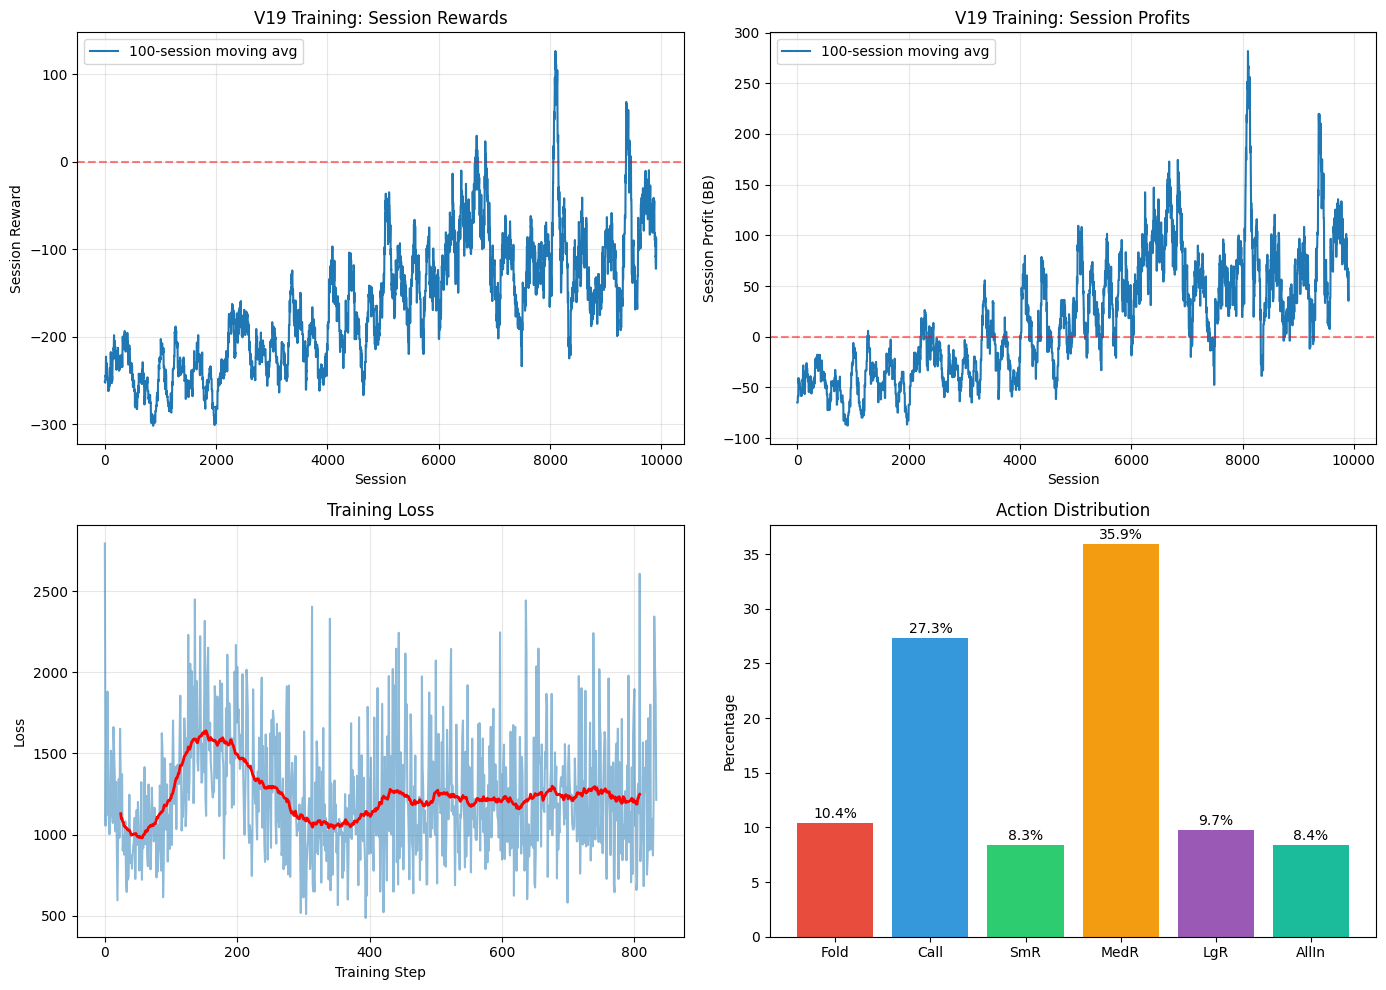

In [9]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Session rewards
ax = axes[0, 0]
window = 100
rewards = history['session_rewards']
if len(rewards) >= window:
    smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax.plot(smoothed, label=f'{window}-session moving avg')
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Session')
ax.set_ylabel('Session Reward')
ax.set_title('V19 Training: Session Rewards')
ax.legend()
ax.grid(True, alpha=0.3)

# Session profits
ax = axes[0, 1]
profits = history['session_profits']
if len(profits) >= window:
    smoothed = np.convolve(profits, np.ones(window)/window, mode='valid')
    ax.plot(smoothed, label=f'{window}-session moving avg')
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Session')
ax.set_ylabel('Session Profit (BB)')
ax.set_title('V19 Training: Session Profits')
ax.legend()
ax.grid(True, alpha=0.3)

# Loss
ax = axes[1, 0]
if history['loss']:
    ax.plot(history['loss'], alpha=0.5)
    if len(history['loss']) >= 50:
        smoothed = np.convolve(history['loss'], np.ones(50)/50, mode='valid')
        ax.plot(range(24, 24+len(smoothed)), smoothed, 'r-', linewidth=2)
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.grid(True, alpha=0.3)

# Action distribution
ax = axes[1, 1]
action_names = ['Fold', 'Call', 'SmR', 'MedR', 'LgR', 'AllIn']
counts = [history['action_counts'][i] for i in range(6)]
total = sum(counts)
pcts = [c/total*100 for c in counts]
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
ax.bar(action_names, pcts, color=colors)
ax.set_ylabel('Percentage')
ax.set_title('Action Distribution')
for i, p in enumerate(pcts):
    ax.text(i, p + 0.5, f'{p:.1f}%', ha='center')

plt.tight_layout()
plt.savefig('v19_training_curves.png', dpi=150)
plt.show()

In [10]:
# Save the model
torch.save({
    'model_state_dict': agent.policy_net.state_dict(),
    'target_state_dict': agent.target_net.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'history': history,
    'opponent_pool': agent.opponent_pool,
    'config': {
        'state_dim': STATE_DIM,
        'hidden_dim': 512,
        'num_actions': NUM_ACTIONS,
        'hands_per_session': HANDS_PER_SESSION,
        'bust_penalty': -200,
        'allin_loss_penalty': -15,
    }
}, 'poker_agent_v19.pt')
print("Model saved to poker_agent_v19.pt")

Model saved to poker_agent_v19.pt
